In [1]:
import sys
import os

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, scale, \
    metrics_r, get_device, plot_history

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train

## Settings

In [5]:
# Set Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [7]:
targets = ["StartYear", "YearRange"]

## Data

### Read Features and Targets

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


In [9]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
	},
}


In [10]:
print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1719, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


### Train-Validation Split

In [11]:
X, y = train_val_split(X, y)

In [12]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
		

In [13]:
print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1547, 2)
	val: 
		<class 'numpy.ndarray'>
		shape   = (172, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


### Scale Regression Targets

In [14]:
y, y_scaler = scale(y)

In [15]:
y = {subset: torch.tensor(_y, dtype=torch.float32, device=device) for subset, _y in y.items()}
print_info_targets(y)

{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1547, 2])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([172, 2])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
}


### Dimensions

In [16]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


### Torch Datasets and Dataloaders

In [17]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## MLP: Pottery Chronology Predictor - Year Regressor



### Initialize Models

In [18]:
hidden_size = 256

models = {
             ft: PotteryChronologyPredictor([X_dim[ft]], y_dim, hidden_size, device, chronology_target="years")
             for ft in feature_types
         } | {
             ft_txt + " + " + ft_img: PotteryChronologyPredictor([X_dim[ft_txt], X_dim[ft_img]], y_dim, hidden_size, device, chronology_target="years")
             for ft_txt, ft_img in feature_type_combos
         }

In [19]:
for ft, model in models.items():
    print(f"\n\nMODEL SUMMARY - FEATURE TYPE: {ft.upper()}")
    model.summary()



MODEL SUMMARY - FEATURE TYPE: TFIDF
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --  

### Train Models



** FEATURE SET: TFIDF **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1168.33it/s, loss=0.7478]


** Early stop | ran: 16/50 epochs | final: epoch 06 | train_loss: 0.5516, val_loss: 0.7108, mae: [38.41, 10.76], rmse: [49.97, 12.99], r2: [0.50, 0.16], medae: [29.51, 10.15], 


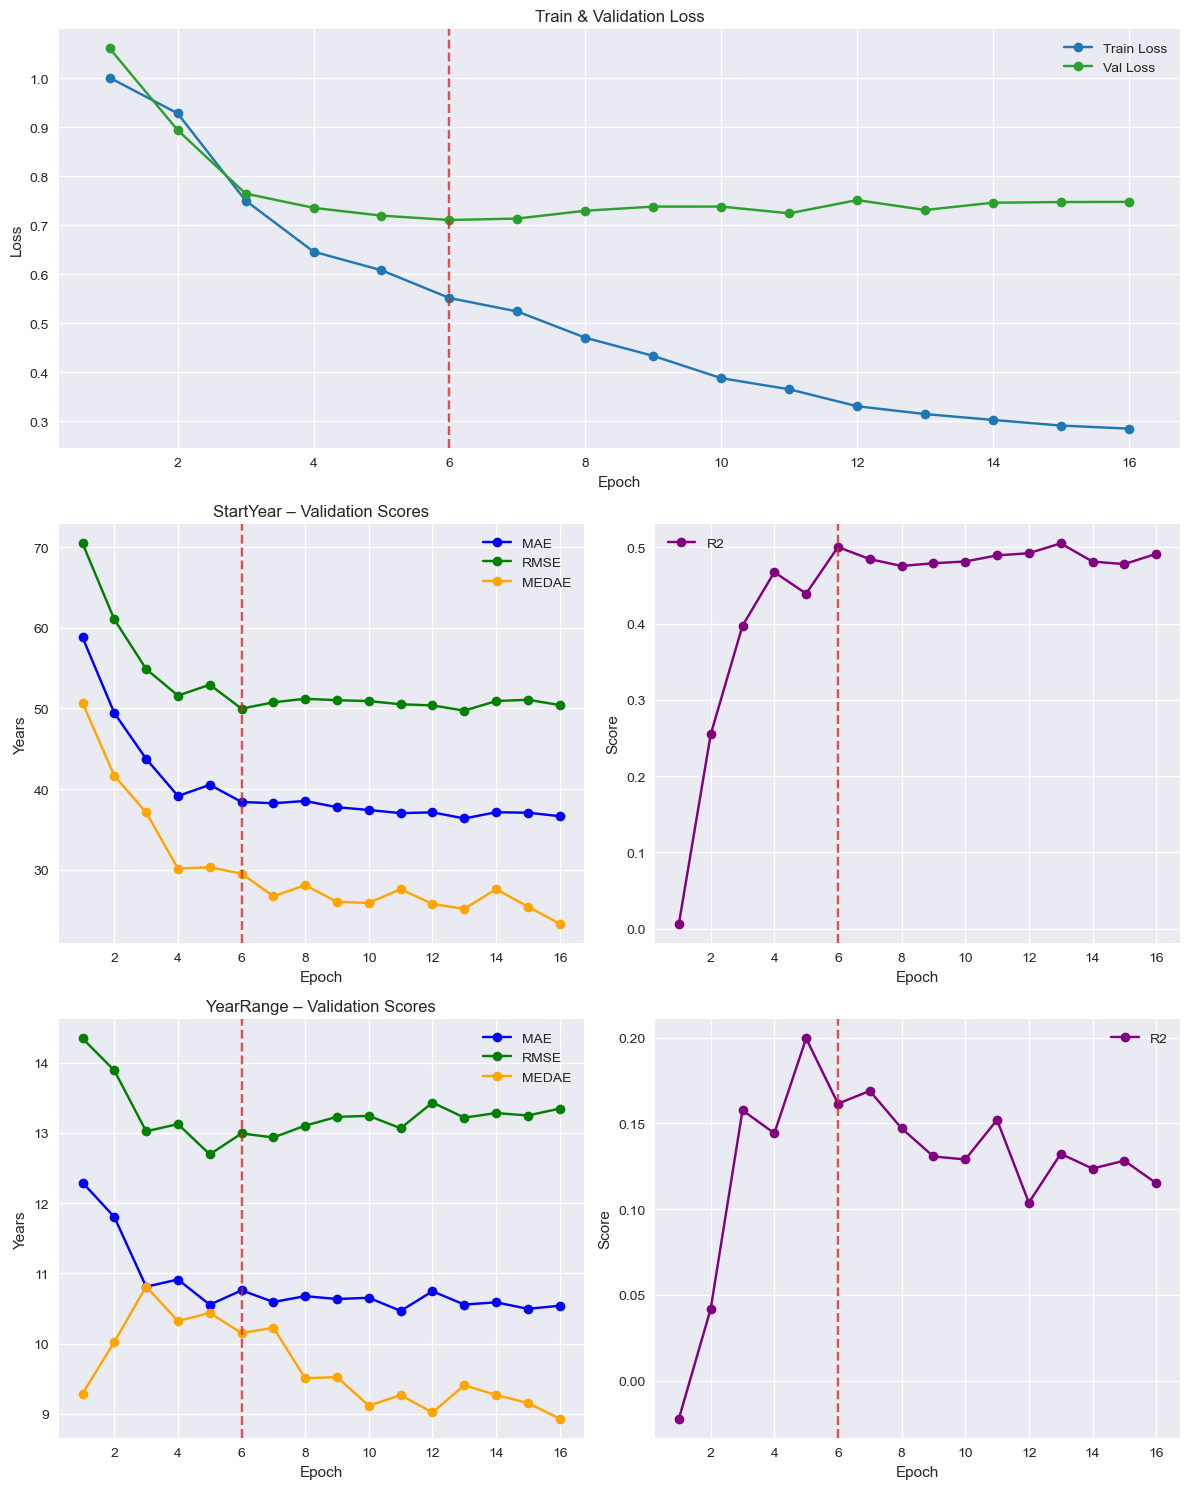



** FEATURE SET: BERT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1197.12it/s, loss=0.8598]


** Early stop | ran: 42/50 epochs | final: epoch 32 | train_loss: 0.6249, val_loss: 0.8446, mae: [45.24, 11.37], rmse: [58.39, 13.82], r2: [0.32, 0.05], medae: [34.92, 10.75], 


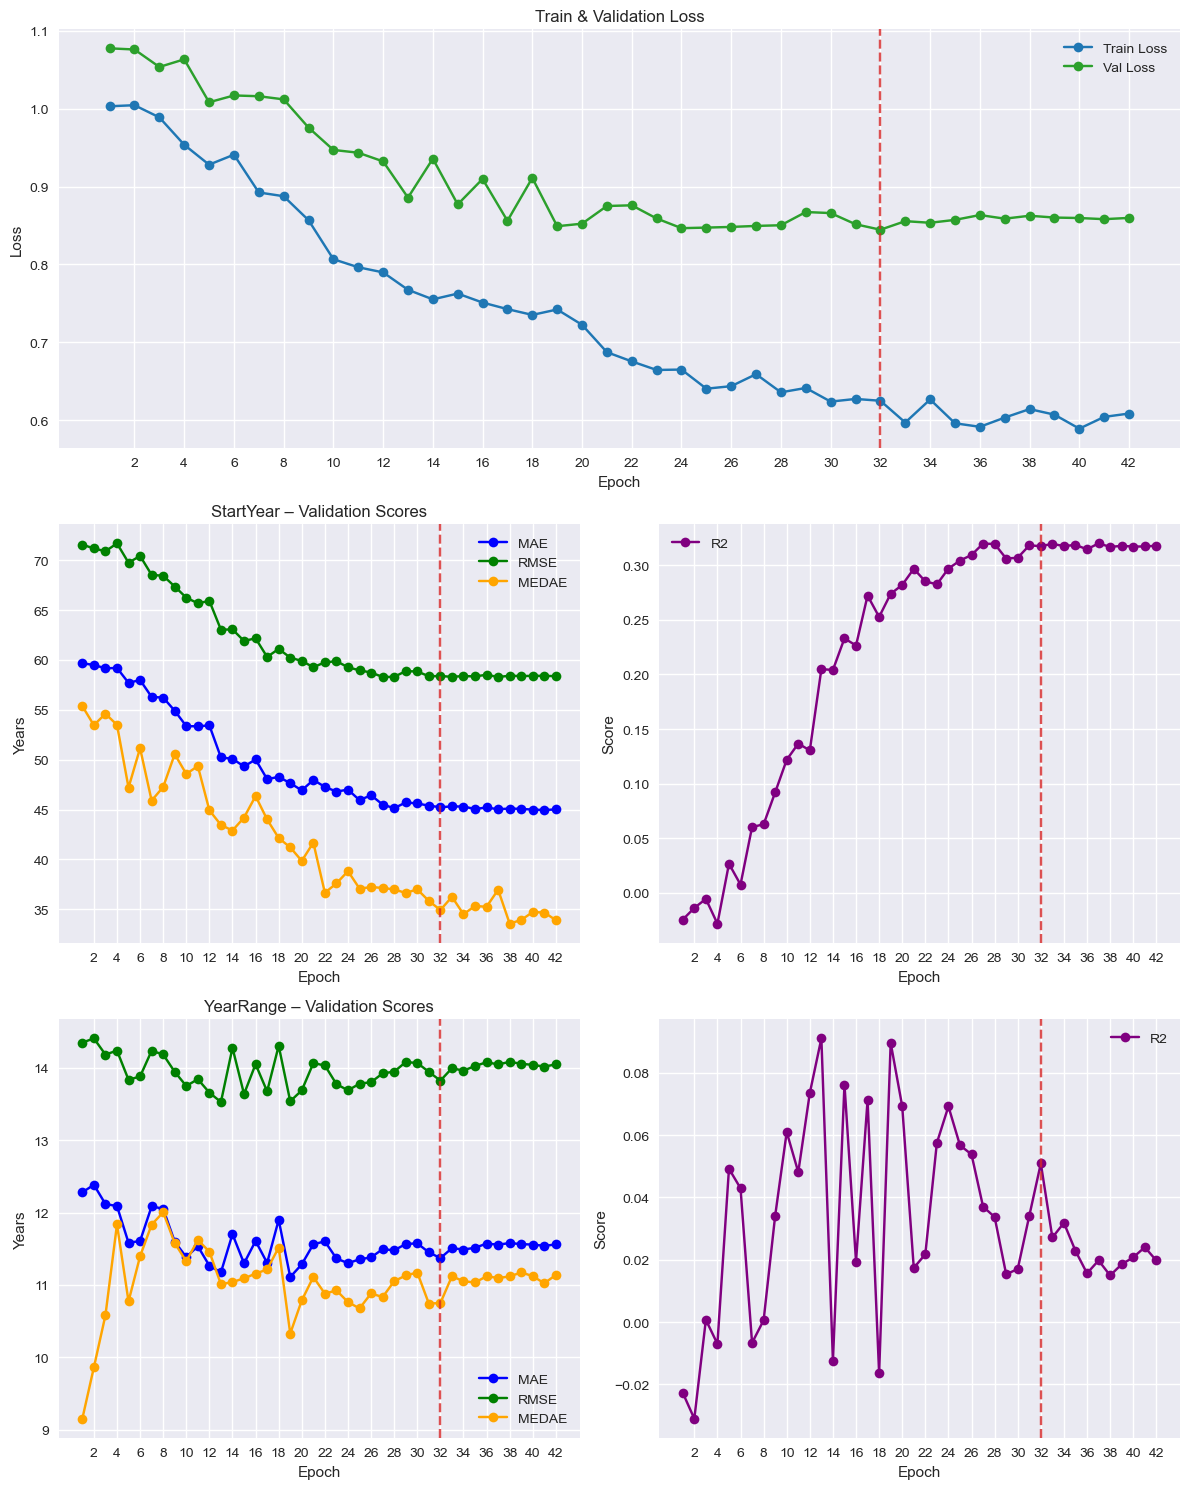



** FEATURE SET: CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 984.42it/s, loss=1.0765]


** Early stop | ran: 24/50 epochs | final: epoch 14 | train_loss: 1.0042, val_loss: 1.0758, mae: [59.26, 12.35], rmse: [71.07, 14.39], r2: [-0.01, -0.03], medae: [54.88, 9.64], 


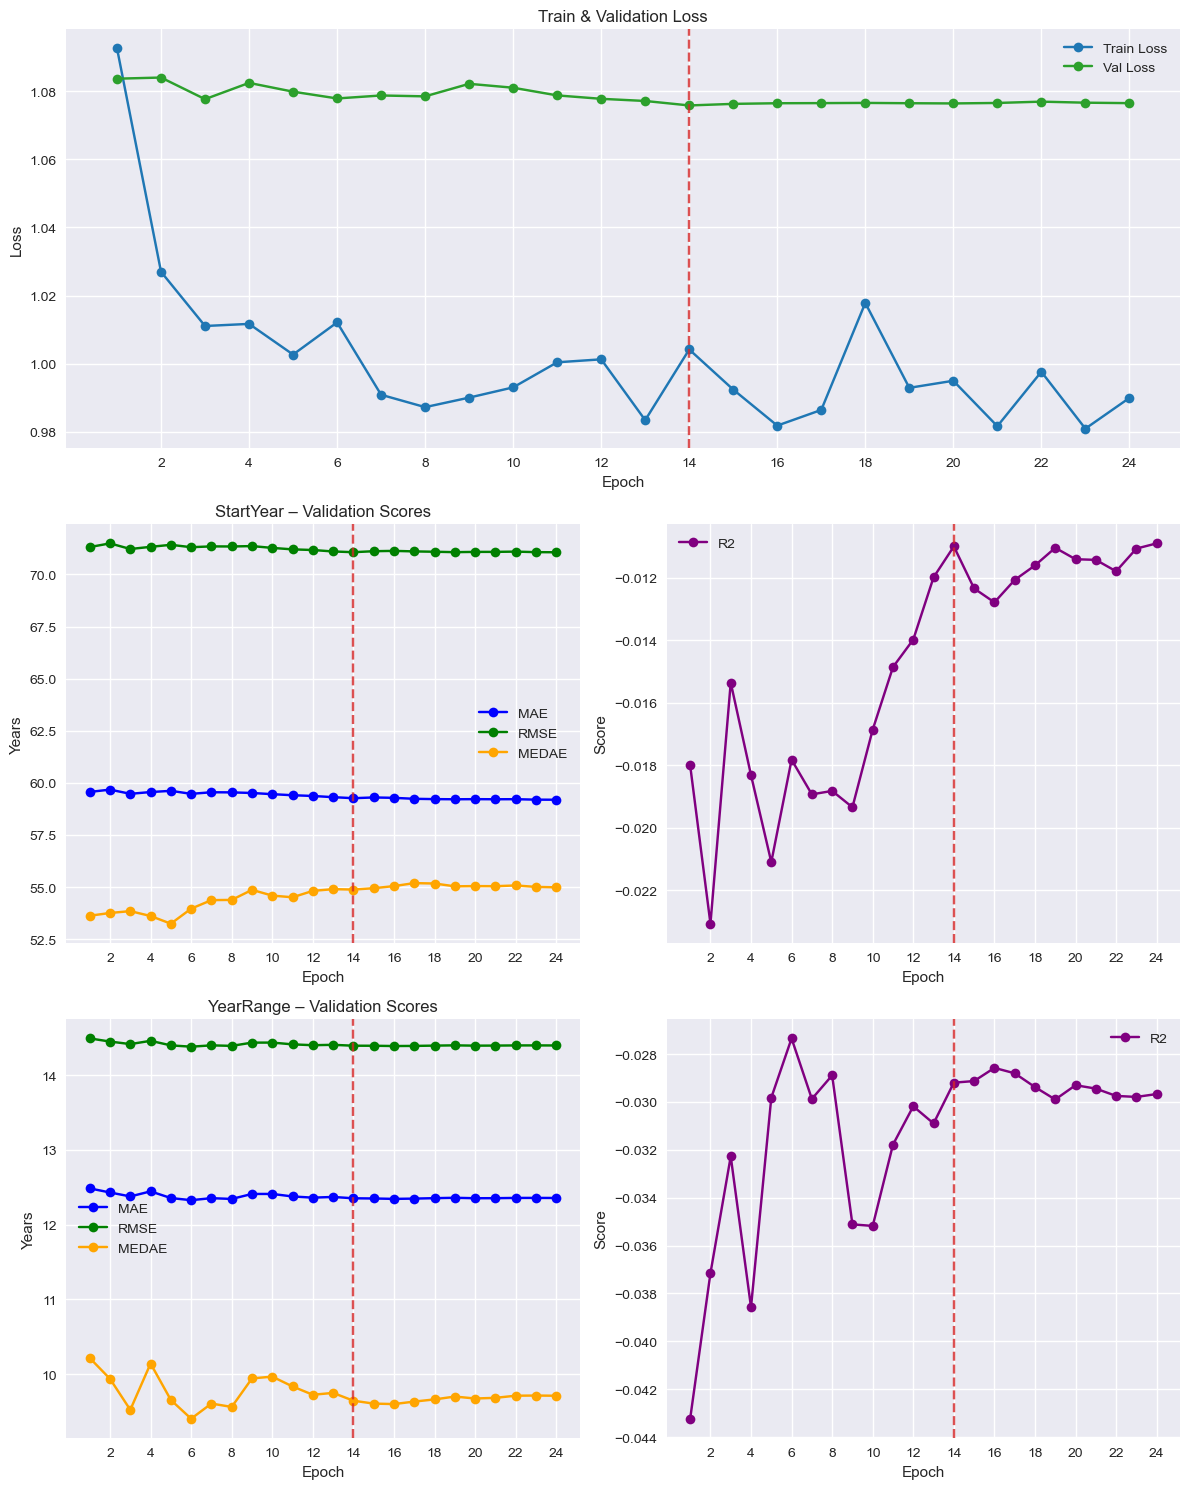



** FEATURE SET: RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 830.45it/s, loss=0.9766]


** Early stop | ran: 18/50 epochs | final: epoch 08 | train_loss: 0.7871, val_loss: 0.9416, mae: [51.04, 12.13], rmse: [62.94, 14.29], r2: [0.21, -0.01], medae: [43.80, 9.89], 


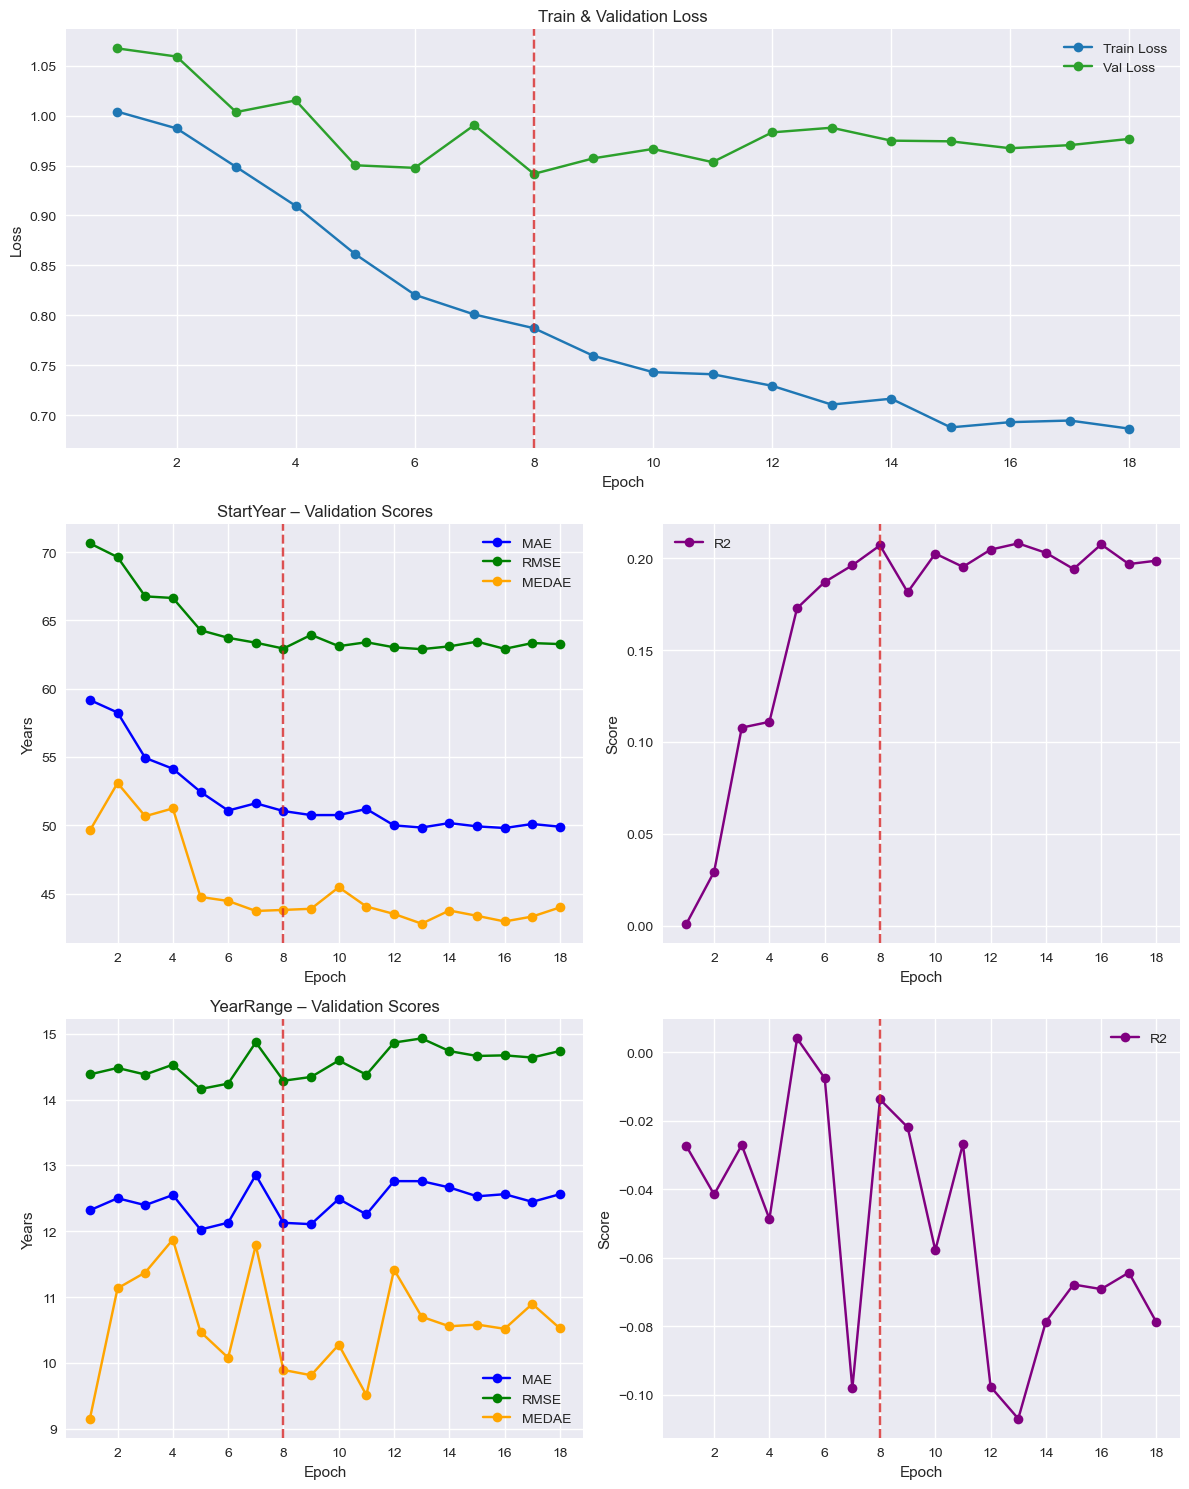



** FEATURE SET: VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1195.30it/s, loss=0.9484]


** Early stop | ran: 22/50 epochs | final: epoch 12 | train_loss: 0.7532, val_loss: 0.9234, mae: [48.57, 11.57], rmse: [62.01, 14.12], r2: [0.23, 0.01], medae: [39.95, 8.65], 


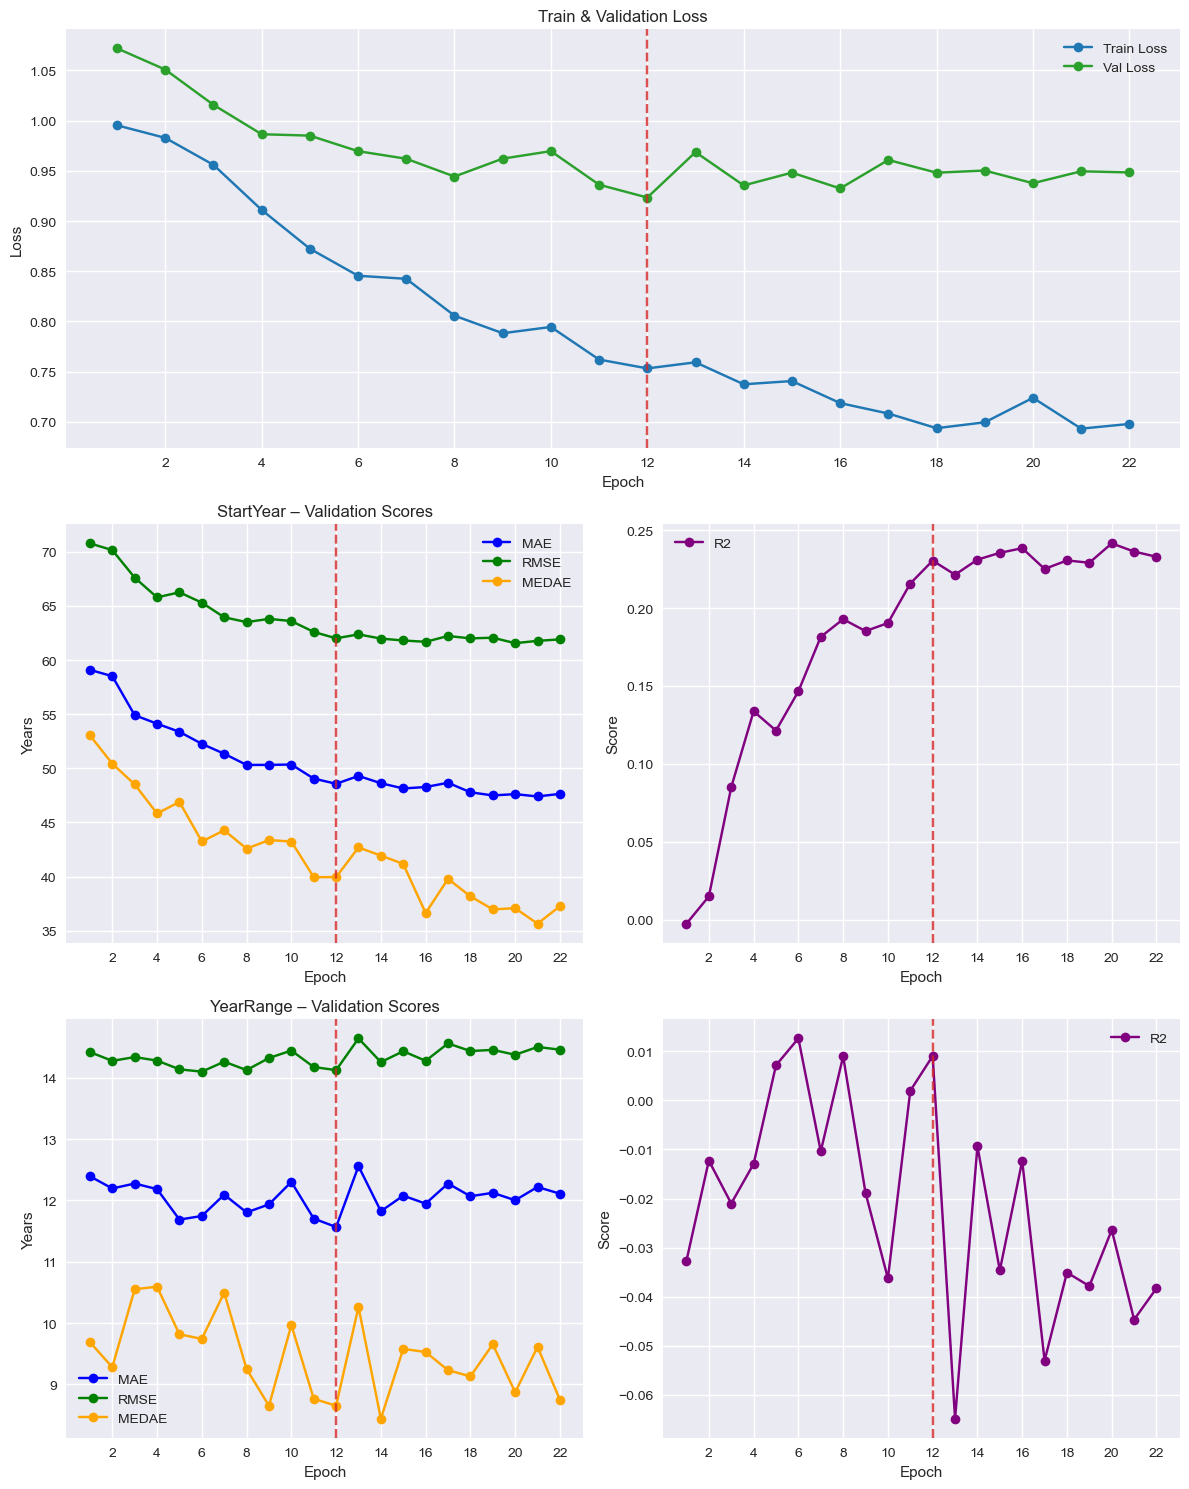



** FEATURE SET: TFIDF + CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 753.02it/s, loss=0.7519]


** Early stop | ran: 22/50 epochs | final: epoch 12 | train_loss: 0.4703, val_loss: 0.7114, mae: [38.65, 10.35], rmse: [52.11, 12.67], r2: [0.46, 0.20], medae: [24.25, 9.39], 


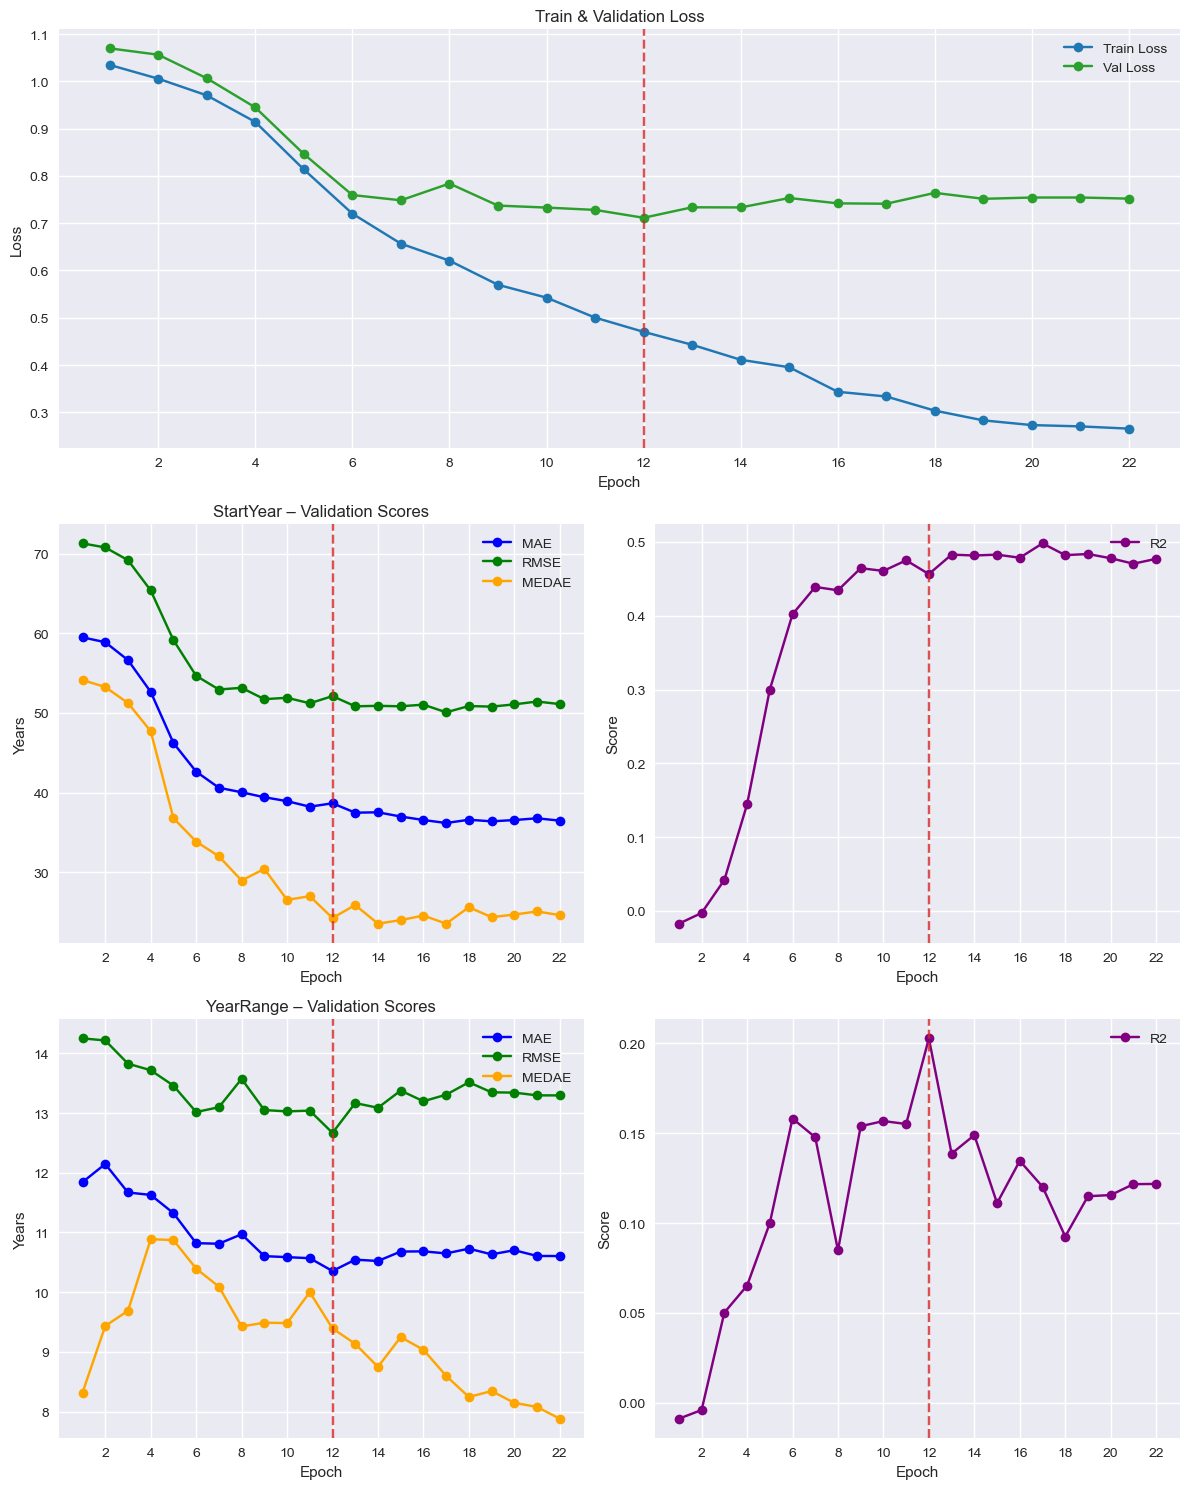



** FEATURE SET: TFIDF + RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 893.48it/s, loss=0.6972]


** Early stop | ran: 19/50 epochs | final: epoch 09 | train_loss: 0.4352, val_loss: 0.6579, mae: [35.41, 10.53], rmse: [44.87, 12.97], r2: [0.60, 0.16], medae: [29.13, 9.13], 


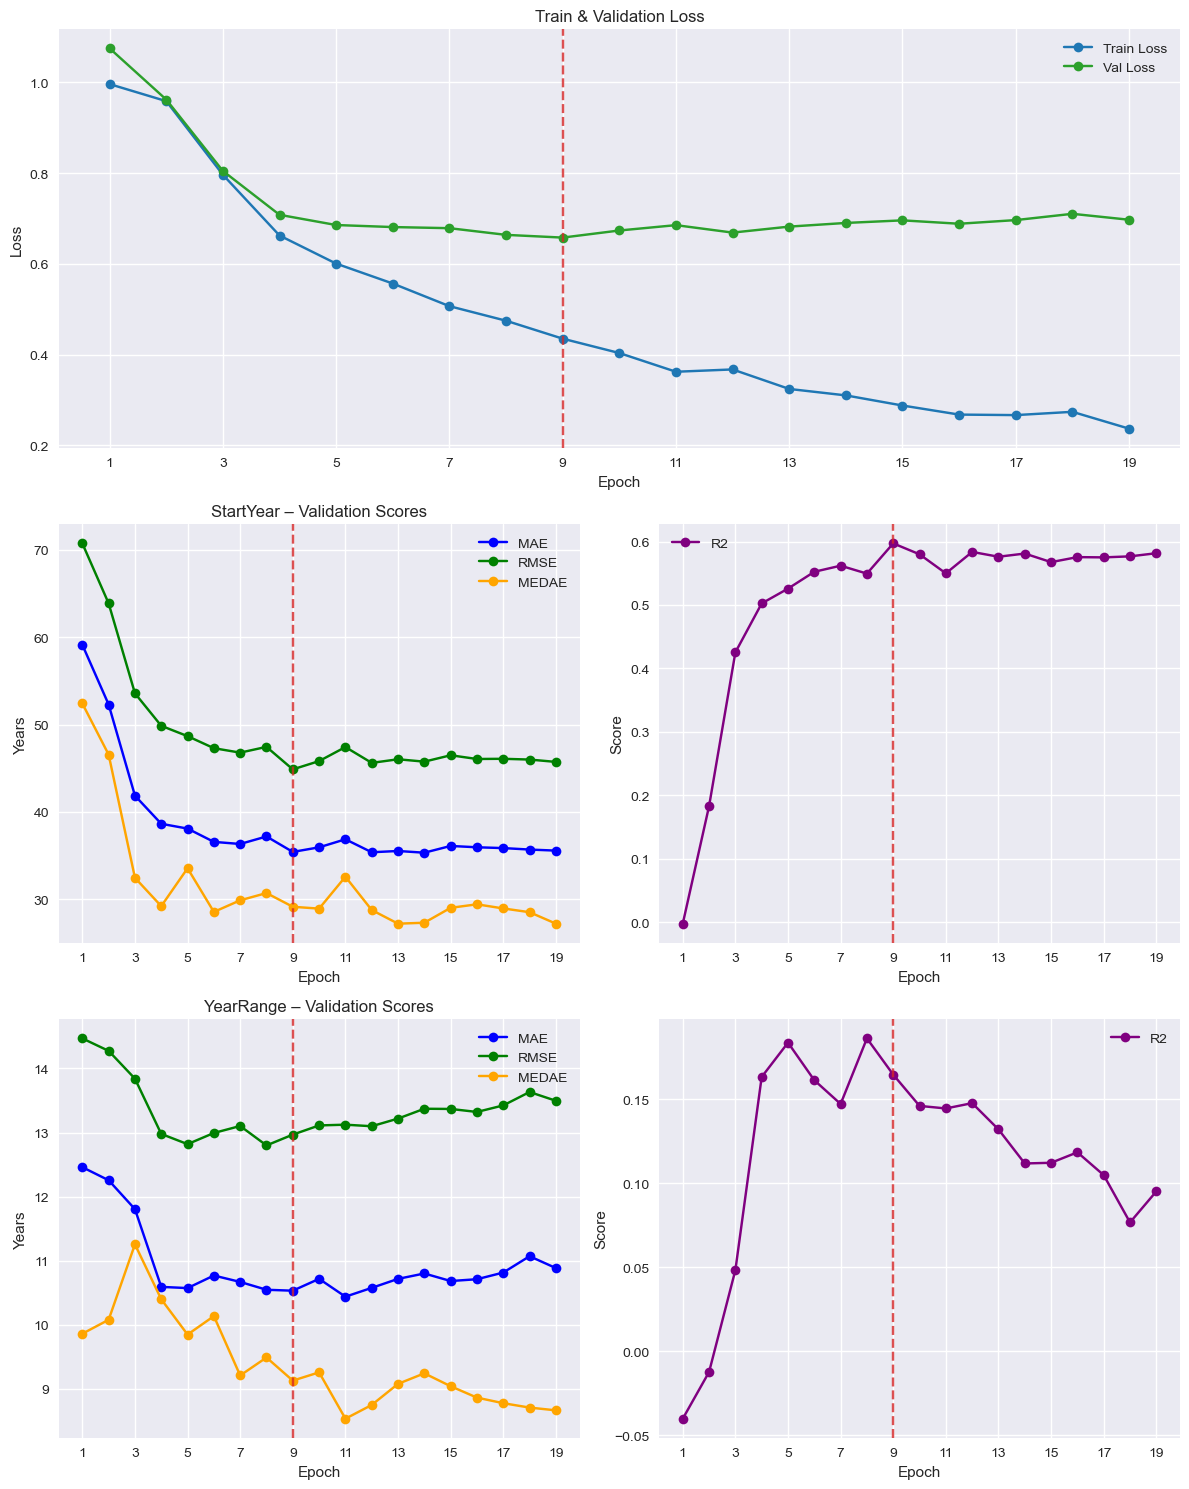



** FEATURE SET: TFIDF + VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 999.91it/s, loss=0.7166]


** Early stop | ran: 15/50 epochs | final: epoch 05 | train_loss: 0.5813, val_loss: 0.6847, mae: [36.20, 10.46], rmse: [48.43, 12.82], r2: [0.53, 0.18], medae: [23.46, 8.88], 


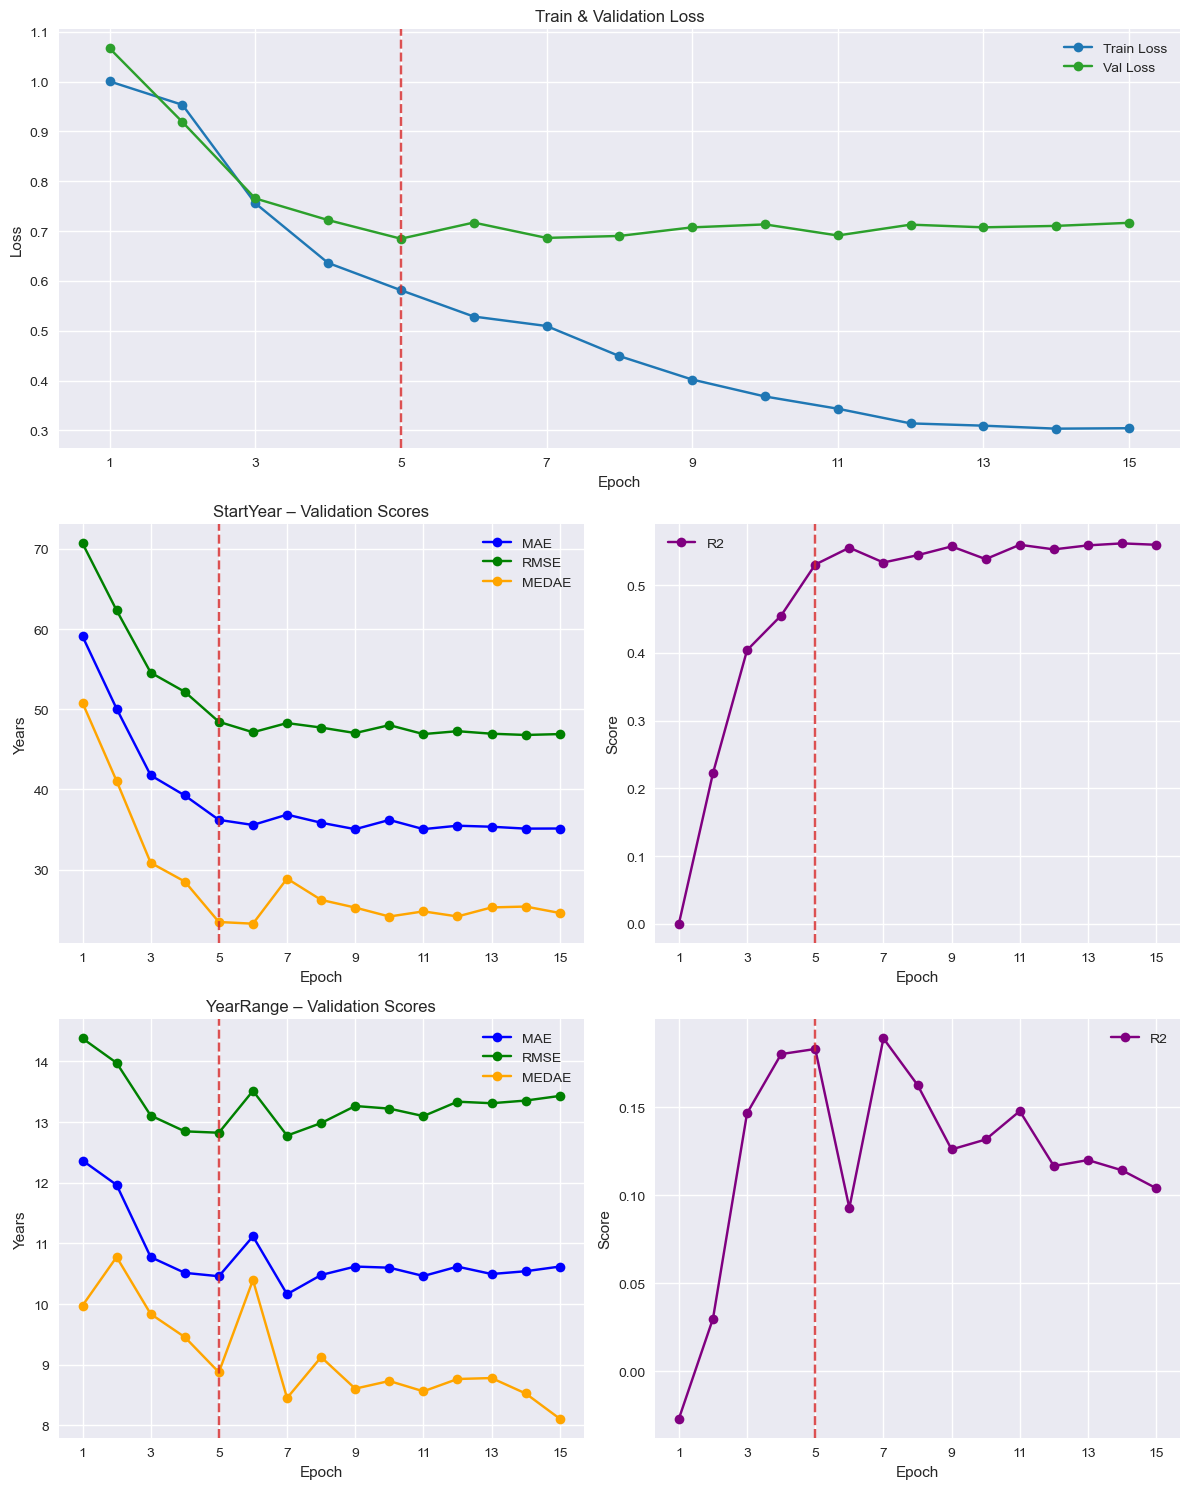



** FEATURE SET: BERT + CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 853.95it/s, loss=0.8341]


** Early stop | ran: 46/50 epochs | final: epoch 36 | train_loss: 0.6024, val_loss: 0.8290, mae: [43.69, 11.35], rmse: [57.51, 13.77], r2: [0.34, 0.06], medae: [34.32, 10.92], 


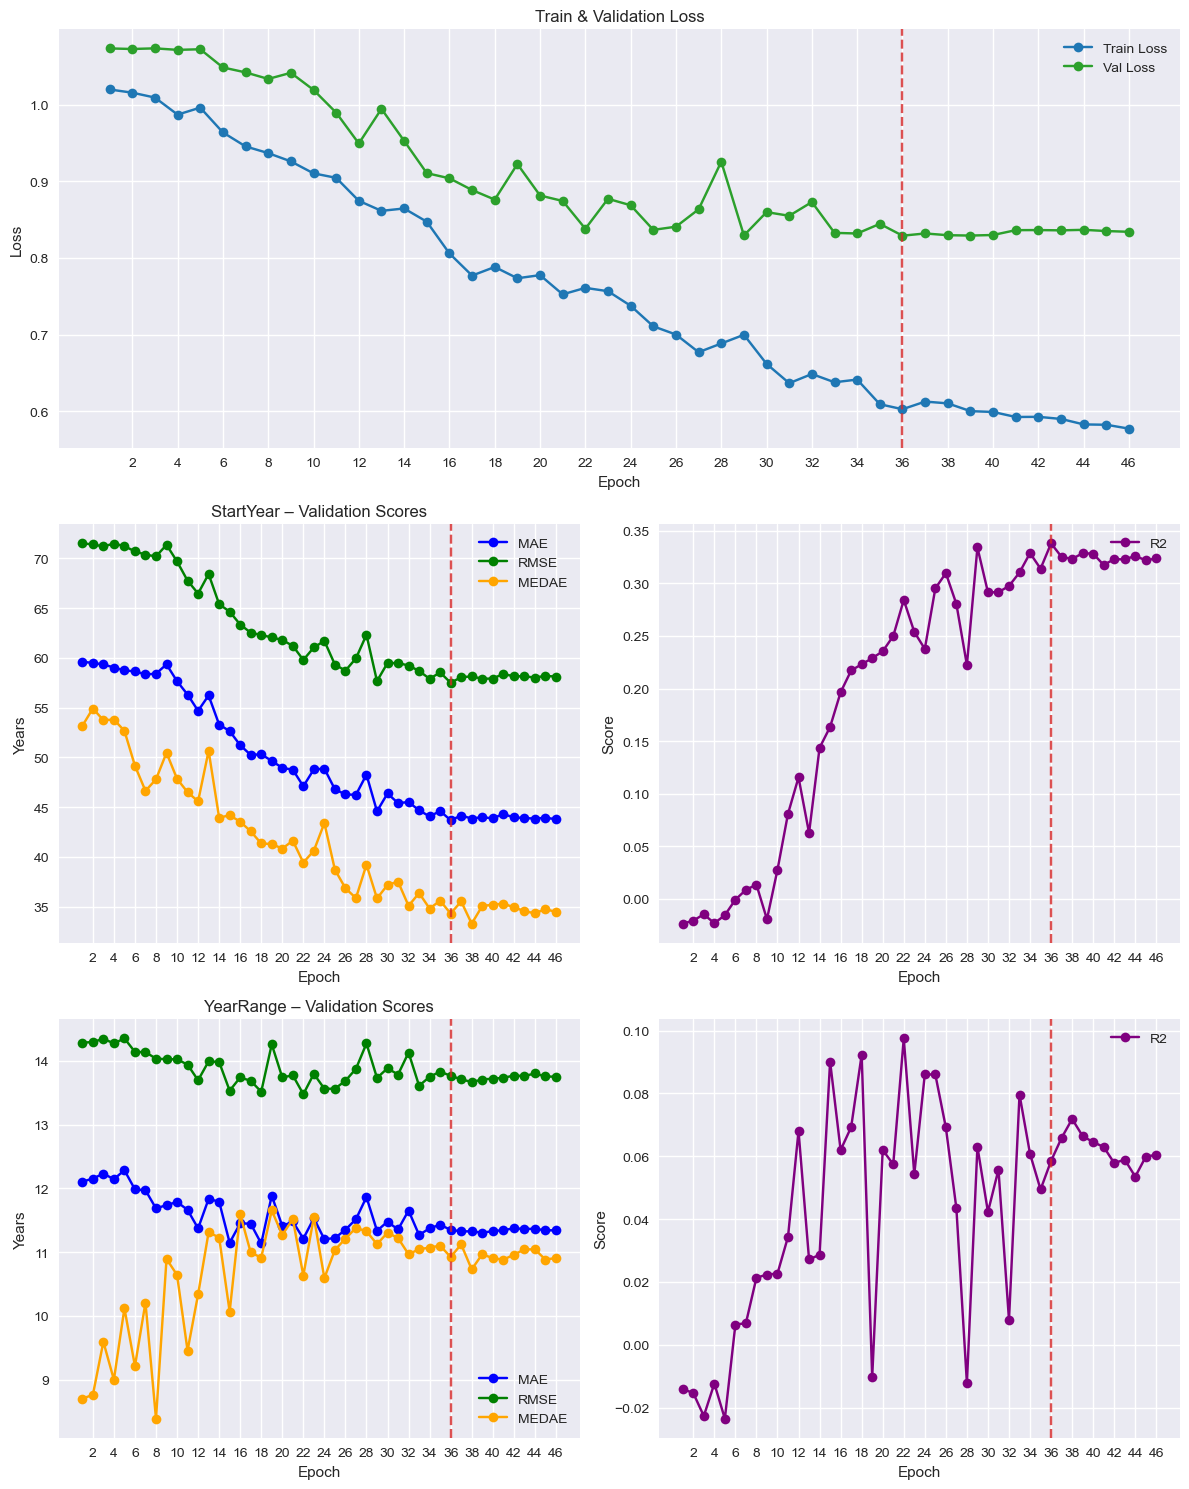



** FEATURE SET: BERT + RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 996.67it/s, loss=0.8245]


** Early stop | ran: 32/50 epochs | final: epoch 22 | train_loss: 0.4859, val_loss: 0.8078, mae: [41.53, 11.49], rmse: [55.26, 13.82], r2: [0.39, 0.05], medae: [32.27, 10.24], 


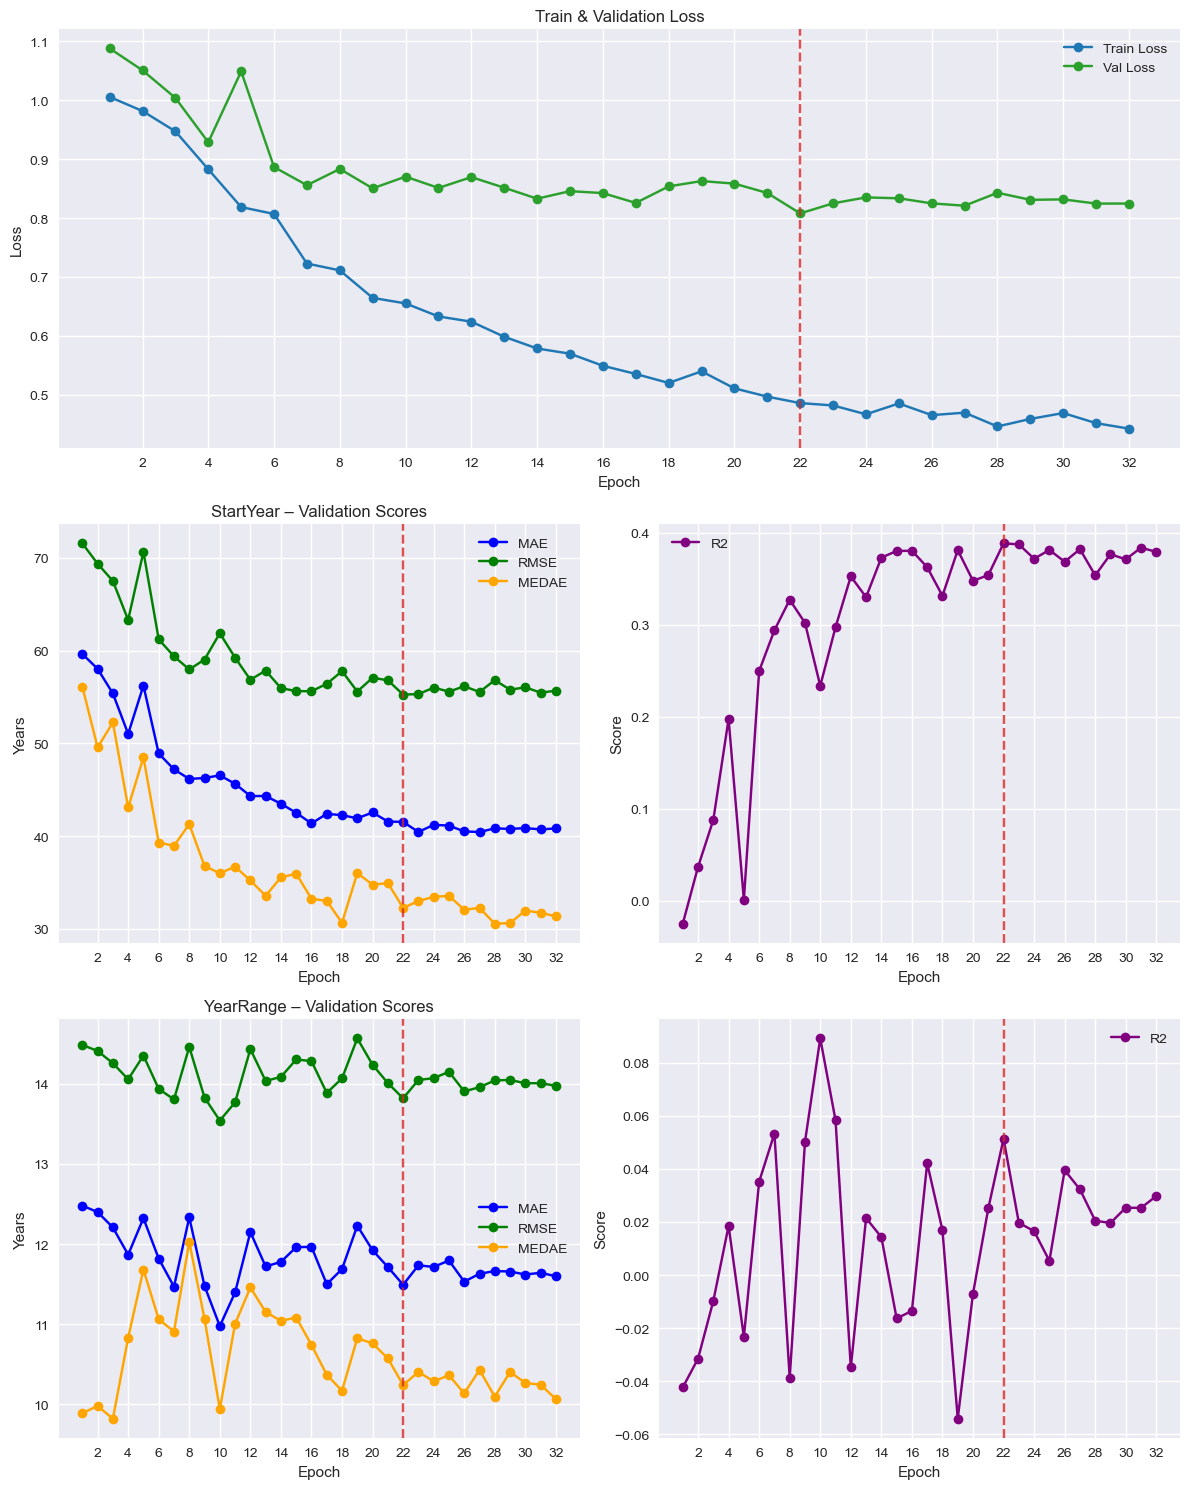



** FEATURE SET: BERT + VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 598.30it/s, loss=0.7970]


** Early stop | ran: 25/50 epochs | final: epoch 15 | train_loss: 0.5789, val_loss: 0.7751, mae: [41.43, 10.86], rmse: [53.74, 13.51], r2: [0.42, 0.09], medae: [34.41, 9.79], 


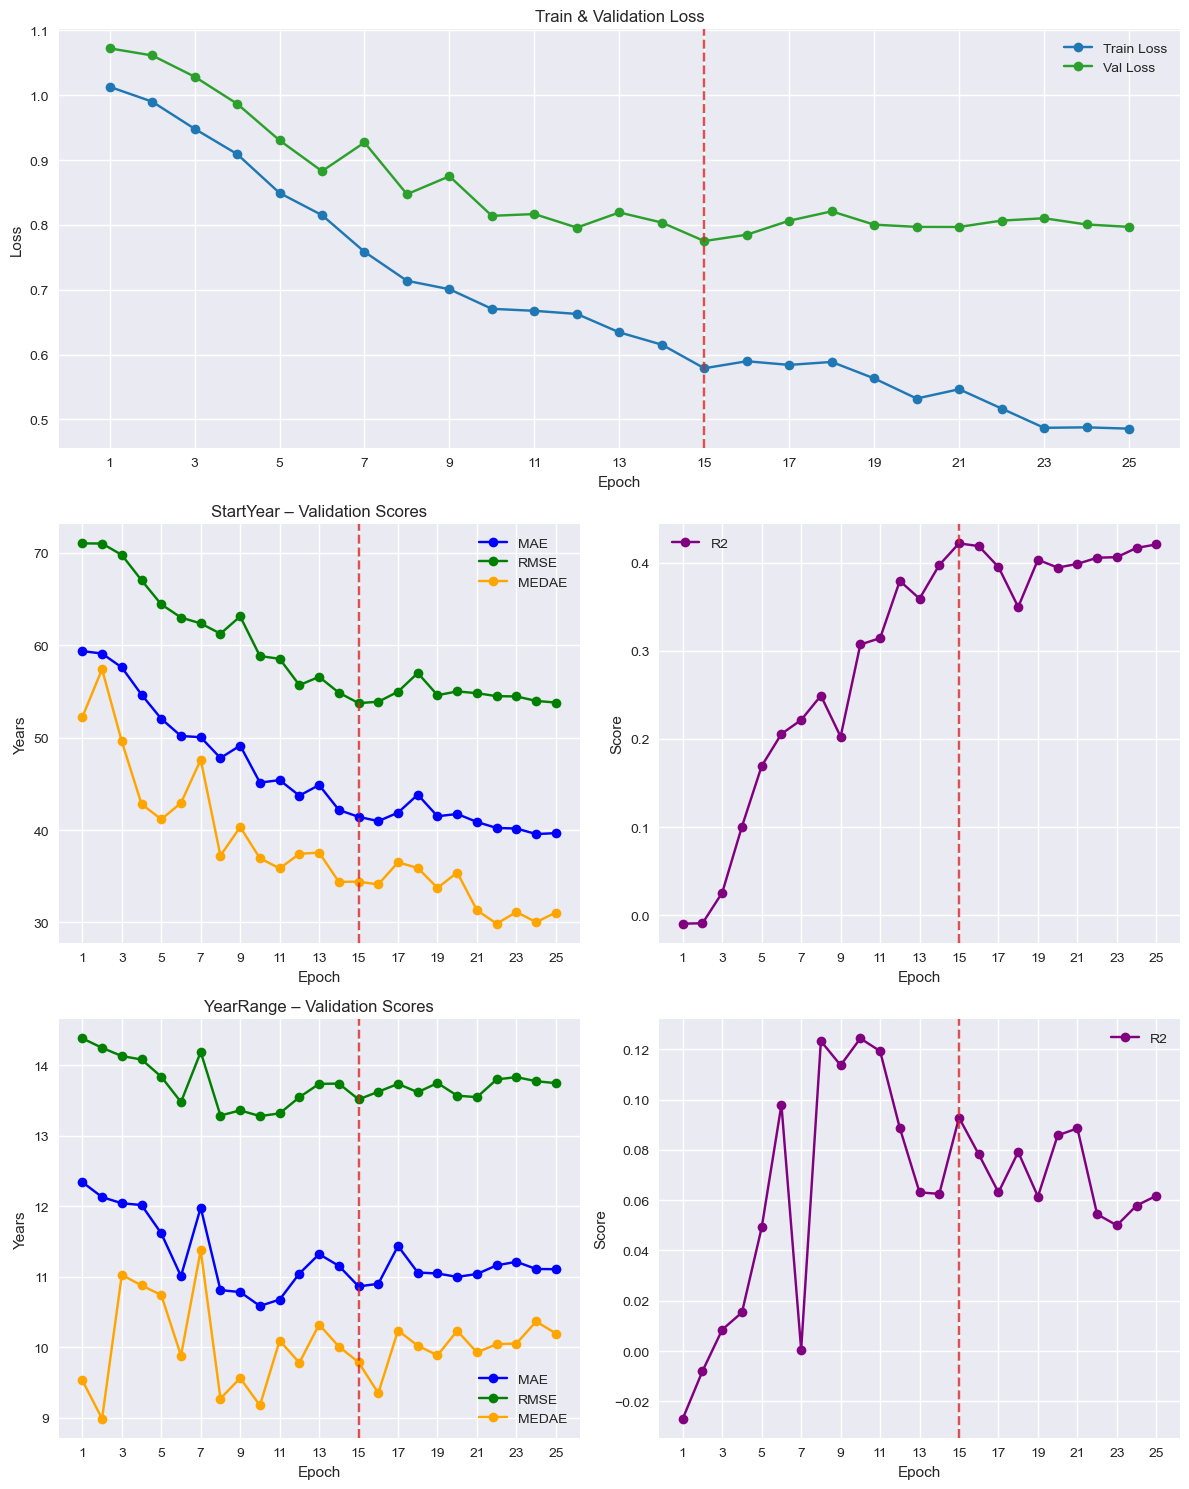

In [20]:
criterion = nn.MSELoss()
metrics = metrics_r

for ft, model in models.items():
    print(f"\n\n** FEATURE SET: {ft.upper()} **")
    models[ft], history = train(model, loaders["train"][ft], loaders["val"][ft], criterion, metrics, y_scaler)
    plot_history(history, targets)